In [1]:
import numpy as np

import matplotlib.pyplot as plt

from photutils.datasets import apply_poisson_noise
from astropy.modeling import models
from astropy.wcs import WCS
from astropy.stats import gaussian_fwhm_to_sigma
import astropy.units as u

from specreduce.calibration_data import load_pypeit_calibration_lines
from specreduce.utils.synth_data import make_2d_arc_image, make_2dspec_image

In [2]:
%load_ext autoreload
%autoreload 2

np.random.seed(8675309)

In [3]:
nx = 3000
ny = 1000
const = 5
noise = 5
width = 5
center = ny / 2
x = np.arange(nx)
y = np.arange(ny)
xx, yy = np.meshgrid(x, y)
profile = models.Moffat1D()
wave_unit = u.Angstrom 
extent = [3500, 7000]

In [5]:
wcs = WCS(naxis=2)
wcs.wcs.ctype[0] = 'WAVE'
wcs.wcs.ctype[1] = 'PIXEL'
wcs.wcs.cunit[0] = wave_unit
wcs.wcs.cunit[1] = u.pixel
wcs.wcs.crval[0] = extent[0]
wcs.wcs.cdelt[0] = (extent[1] - extent[0]) / nx
wcs.wcs.crval[1] = 0
wcs.wcs.cdelt[1] = 1
wcs.spectral

WCS Keywords

Number of WCS axes: 1
CTYPE : 'WAVE'  
CRVAL : 3.5000000000000004e-07  
CRPIX : 0.0  
PC1_1  : 1.0  
CDELT : 1.1666666666666668e-10  
NAXIS : 0  0

In [6]:
ll = load_pypeit_calibration_lines('HeI')
ll

ion,wave,NIST,Instr,amplitude,Source
,Angstrom,,,,
str3,float64,int64,int64,int64,str20
HeI,3889.75,1,4,2565,kastb_600_PYPIT.json
HeI,4027.3292,1,4,153,kastb_600_PYPIT.json
HeI,4472.735,1,0,30,ALFOSC
HeI,4714.4644,1,4,275,kastb_600_PYPIT.json
HeI,4923.3053,1,4,656,kastb_600_PYPIT.json
HeI,5017.0772,1,4,2341,kastb_600_PYPIT.json
HeI,5877.249,1,0,1000,FORS2
HeI,6679.995,1,0,300,ALFOSC


In [7]:
#wcs.spectral.world_to_pixel(ll['wave'].value * ll['wave'].unit)
wcs.spectral.world_to_pixel(ll['wave'])

array([ 333.07142857,  450.99645714,  832.77285714, 1039.96948571,
       1218.97597143, 1299.35188571, 2036.642     , 2724.71      ,
       3056.54685714])

In [8]:
profile.amplitude = 10
profile.alpha = 0.1
trace_mod = models.Chebyshev1D(degree=3, c0=0, c1=50, c2=100)
trace = yy - center + trace_mod(xx/nx)
z = const + profile(trace)
noisy = apply_poisson_noise(z)

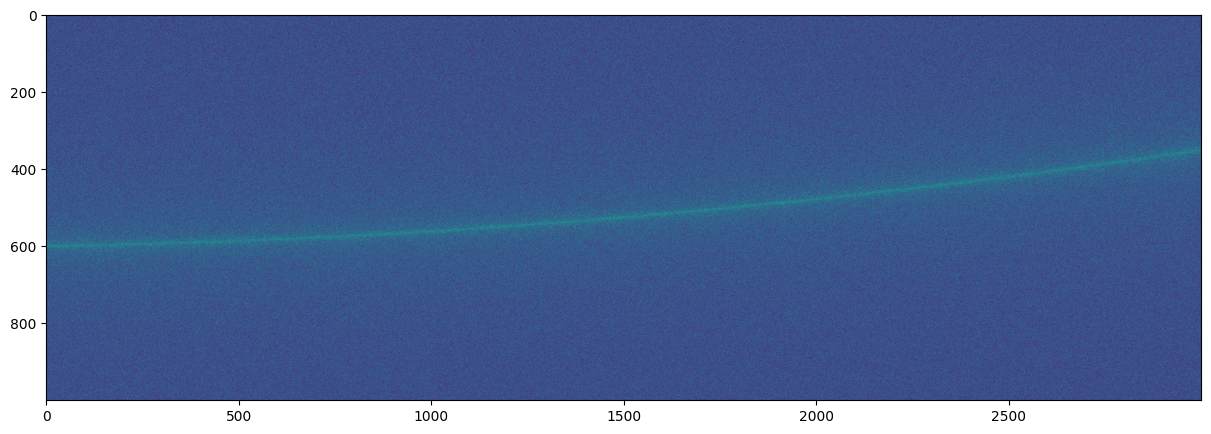

In [9]:
fig = plt.figure(figsize=(15, 5))
plt.imshow(noisy)
plt.show()

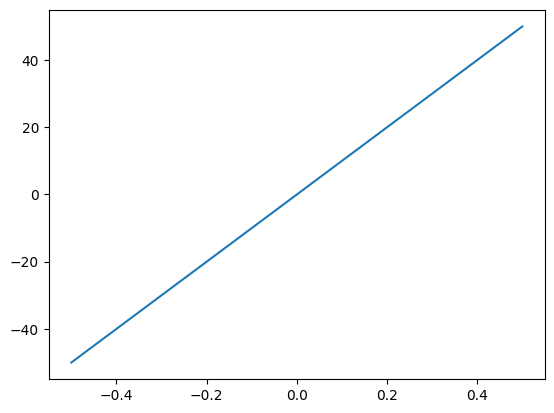

In [71]:
model2 = models.Legendre1D(degree=2, c0=50, c1=0, c2=100)
model1 = models.Legendre1D(degree=1, c0=0, c1=100)
x = (np.arange(3000)-1500)/3000
y = model(x)
plt.plot(x, y)

In [19]:
xx + model((yy/2 - yy)/ny)

array([[0.00000000e+00, 1.00000000e+00, 2.00000000e+00, ...,
        2.99700000e+03, 2.99800000e+03, 2.99900000e+03],
       [1.87500000e-05, 1.00001875e+00, 2.00001875e+00, ...,
        2.99700002e+03, 2.99800002e+03, 2.99900002e+03],
       [7.50000000e-05, 1.00007500e+00, 2.00007500e+00, ...,
        2.99700007e+03, 2.99800007e+03, 2.99900007e+03],
       ...,
       [1.86376688e+01, 1.96376688e+01, 2.06376688e+01, ...,
        3.01563767e+03, 3.01663767e+03, 3.01763767e+03],
       [1.86750750e+01, 1.96750750e+01, 2.06750750e+01, ...,
        3.01567508e+03, 3.01667508e+03, 3.01767508e+03],
       [1.87125188e+01, 1.97125188e+01, 2.07125188e+01, ...,
        3.01571252e+03, 3.01671252e+03, 3.01771252e+03]])

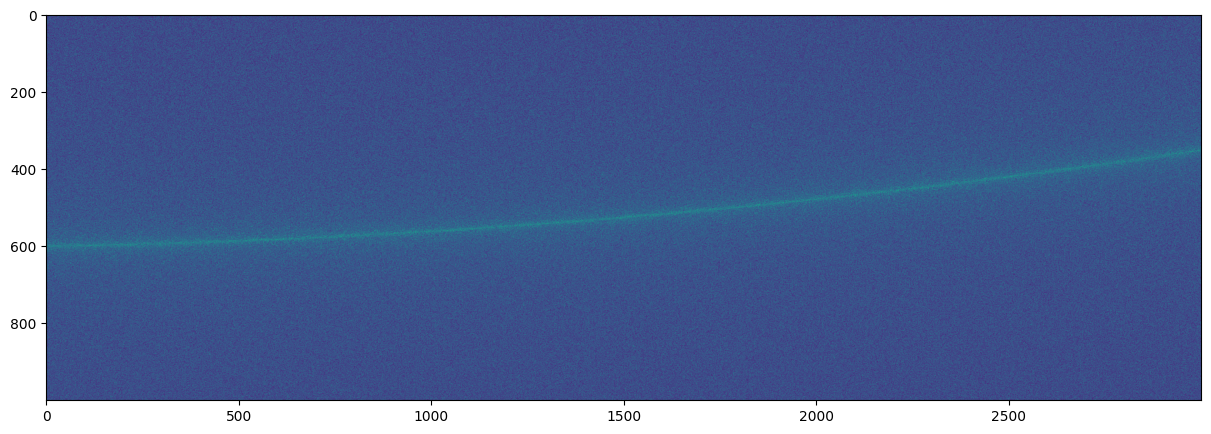

In [11]:
im = make_2dspec_image()
fig = plt.figure(figsize=(15, 5))
plt.imshow(im)

In [72]:
im = make_2d_arc_image(linelists=['HeI', 'ArI', 'ArII'], line_fwhm=3, tilt_func=model2)

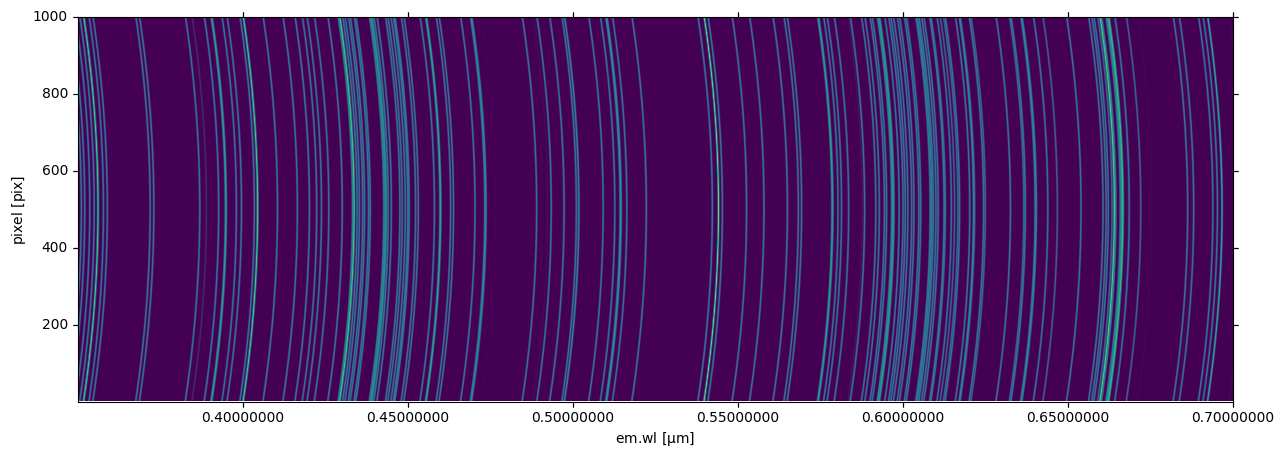

In [74]:
fig = plt.figure(figsize=(15, 5))
ax = plt.subplot(projection=wcs)
wave, pix = ax.coords
wave.set_format_unit(u.um)
plt.imshow(im)

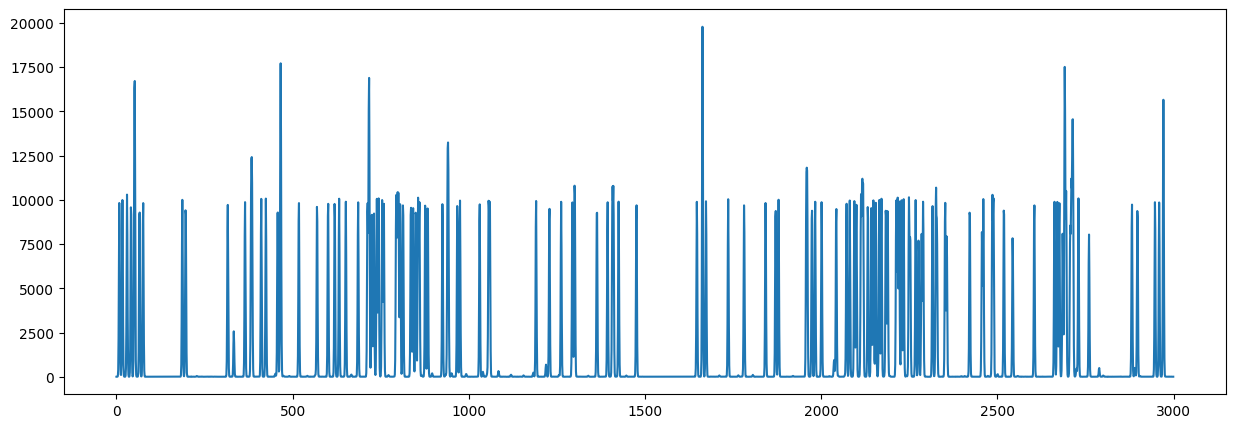

In [67]:
fig = plt.figure(figsize=(15, 5))
plt.plot(im.data[500, :])
plt.show()

In [32]:
type(model)

<class 'astropy.modeling.polynomial.Legendre1D'>
Name: Legendre1D
N_inputs: 1
N_outputs: 1
Fittable parameters: <property object at 0x12ef4d5d0>

In [33]:
isinstance(model, models.Legendre1D)

True

In [69]:
im.wcs.spectral

WCS Keywords

Number of WCS axes: 1
CTYPE : 'WAVE'  
CRVAL : 3.5000000000000004e-07  
CRPIX : 0.0  
PC1_1  : 1.0  
CDELT : 1.1666666666666668e-10  
NAXIS : 0  0